# 台灣銀行牌告匯率爬蟲練習
## 範例1： 練習爬取台幣對其他貨幣匯率資料

In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os

### 進入台灣銀行牌告匯率網頁：https://rate.bot.com.tw/xrt?Lang=zh-TW ，擷取當日台幣對美金的匯率資訊

In [14]:
# 進入台灣銀行牌告匯率網頁，查看當日匯率資料
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
# print(resp.text)  # 如有需要，列印出網頁原始碼

html = BeautifulSoup(resp.text, "lxml")
#attr(jq) 特殊屬性抓取
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 查詢美金(也就是匯率表的第一個元素)對台幣的匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
# print(currency.get_text().replace(" ", ""))  # 去掉空白

buy_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金買入'})
sell_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金賣出'})
# print("即時現金買入: %s, 即時現金賣出: %s" % (buy_rate.get_text(), sell_rate.get_text()))


19

### 作業part 1：請參考上面的範例，試著爬取所有貨幣對台幣的匯率

In [ ]:
for rate in rate_table:
  currency = rate.find(name='div', attrs={'class':'visible-phone print_hide'})
  buy_rate = rate.find(name='td', attrs={'data-table':'本行現金買入'})
  sell_rate = rate.find(name='td', attrs={'data-table':'本行現金賣出'})
  print(currency.get_text().replace(" ", ""))  # 去掉空白
  print("即時現金買入: %s, 即時現金賣出: %s" % (buy_rate.get_text(), sell_rate.get_text()))

## 範例2：爬取一個月的美金對台幣歷史匯率資料，並畫出趨勢圖

In [ ]:
# 先到牌告匯率首頁，爬取所有貨幣的種類
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 貨幣種類

# 針對美金，找到其「歷史匯率」的首頁 
history_link = rate_table[0].find(name='td', attrs={'data-table':'歷史匯率'})
history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁

#
# 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
#
# 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
quote_history_url = history_rate_link.replace("history", "quote/2021-06")
resp = requests.get(quote_history_url)
resp.encoding = 'utf-8'
history = BeautifulSoup(resp.text, "lxml")
history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

#
# 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
#
date_history = list()
history_buy = list()
history_sell = list()

for history_rate in history_table:
    # 擷取日期資料
    date_string = history_rate.a.get_text()
    date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
    date_history.append(date)  # 日期歷史資料

    history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
    history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
    history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

# 將匯率資料建成dataframe形式
HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                    'buy_rate':history_buy,
                                    'sell_rate':history_sell})

HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

os.system('export DISPLAY=:0.0')
# 畫出歷史匯率軌跡圖
plt.figure(figsize=(10, 8))
HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
plt.legend(loc="upper left")
plt.show()


美金(USD)



In [ ]:
#pandas版本
import pandas as pd 

# 先到牌告匯率首頁，爬取所有貨幣的種類
url = "https://rate.bot.com.tw/xrt/quote/2020-03/USD"
resp = requests.get(url)
resp.encoding = 'utf-8'

#
# 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
#
html = BeautifulSoup(resp.text)
print(html.find('tbody').find_all('tr')[0].find_all('td')[0].text)
date_list =[]
sell_list=[]
buy_list=[]
for d in html.find('tbody').find_all('tr'):
    date_list.append(d.find_all('td')[0].text[5:])
    buy_list.append(d.find_all('td')[2].text)
    sell_list.append(d.find_all('td')[3].text)
buy_list = [float(d) for d in buy_list]
sell_list = [float(d) for d in sell_list]
data_list = {'2020 date':date_list,'buy':buy_list,'sell':sell_list}
data_df = pd.DataFrame(data_list)
data_df = data_df.set_index('2020 date')
data_df = data_df.sort_index(ascending=True)
plt.figure(figsize=(10, 8))
data_df[['buy','sell']].plot(kind='line',title='USD')
plt.legend(loc="upper left")
plt.show()

# 將匯率資料建成dataframe形式

# 畫出歷史匯率軌跡圖

### 作業part 2：爬取每種貨幣對台幣的一個月歷史匯率資料，並畫出趨勢圖

/usr/local/Caskroom/miniconda/base/envs/my_test/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rate.bot.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/my_test/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rate.bot.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(



美金(USD)

            buy_rate  sell_rate
date                           
2021/06/01    27.240     27.910
2021/06/02    27.290     27.960
2021/06/03    27.285     27.955
2021/06/04    27.295     27.965
2021/06/07    27.295     27.965
2021/06/08    27.285     27.955
2021/06/09    27.355     28.025
2021/06/10    27.280     27.950
2021/06/11    27.210     27.880
2021/06/15    27.245     27.915
2021/06/16    27.285     27.955
2021/06/17    27.365     28.035
2021/06/18    27.380     28.050
2021/06/21    27.525     28.195
2021/06/22    27.555     28.225
2021/06/23    27.595     28.265
2021/06/24    27.585     28.255
2021/06/25    27.480     28.150
2021/06/28    27.495     28.165
2021/06/29    27.495     28.165
2021/06/30    27.460     28.130


<Figure size 720x576 with 0 Axes>

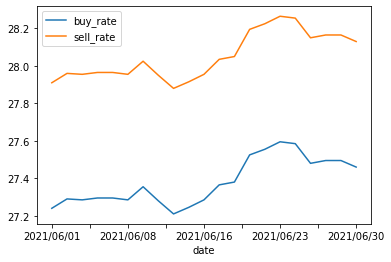


港幣(HKD)



/usr/local/Caskroom/miniconda/base/envs/my_test/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rate.bot.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


            buy_rate  sell_rate
date                           
2021/06/01     3.406      3.610
2021/06/02     3.412      3.616
2021/06/03     3.412      3.616
2021/06/04     3.413      3.617
2021/06/07     3.414      3.618
2021/06/08     3.412      3.616
2021/06/09     3.421      3.625
2021/06/10     3.411      3.615
2021/06/11     3.402      3.606
2021/06/15     3.405      3.609
2021/06/16     3.410      3.614
2021/06/17     3.419      3.623
2021/06/18     3.422      3.626
2021/06/21     3.440      3.644
2021/06/22     3.444      3.648
2021/06/23     3.448      3.652
2021/06/24     3.448      3.652
2021/06/25     3.435      3.639
2021/06/28     3.437      3.641
2021/06/29     3.437      3.641
2021/06/30     3.431      3.635


<Figure size 720x576 with 0 Axes>

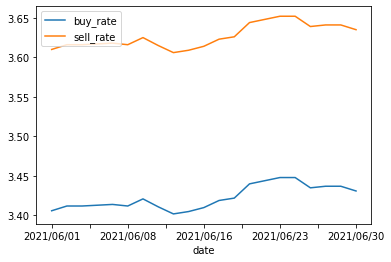


英鎊(GBP)



/usr/local/Caskroom/miniconda/base/envs/my_test/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rate.bot.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


            buy_rate  sell_rate
date                           
2021/06/01     38.11      40.23
2021/06/02     37.96      40.08
2021/06/03     37.97      40.09
2021/06/04     37.90      40.02
2021/06/07     37.94      40.06
2021/06/08     37.95      40.07
2021/06/09     38.15      40.27
2021/06/10     37.81      39.93
2021/06/11     37.92      40.04
2021/06/15     37.83      39.95
2021/06/16     37.89      40.01
2021/06/17     37.61      39.73
2021/06/18     37.39      39.51
2021/06/21     37.43      39.55
2021/06/22     37.62      39.74
2021/06/23     37.94      40.06
2021/06/24     37.87      39.99
2021/06/25     37.58      39.70
2021/06/28     37.63      39.75
2021/06/29     37.47      39.59
2021/06/30     37.33      39.45


<Figure size 720x576 with 0 Axes>

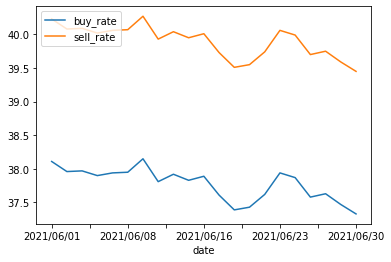


澳幣(AUD)



/usr/local/Caskroom/miniconda/base/envs/my_test/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rate.bot.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


            buy_rate  sell_rate
date                           
2021/06/01     21.05      21.83
2021/06/02     21.02      21.80
2021/06/03     20.98      21.76
2021/06/04     20.83      21.61
2021/06/07     21.05      21.83
2021/06/08     21.04      21.82
2021/06/09     21.11      21.89
2021/06/10     21.01      21.79
2021/06/11     21.05      21.83
2021/06/15     20.90      21.68
2021/06/16     20.93      21.71
2021/06/17     20.75      21.53
2021/06/18     20.56      21.34
2021/06/21     20.54      21.32
2021/06/22     20.58      21.36
2021/06/23     20.75      21.53
2021/06/24     20.80      21.58
2021/06/25     20.79      21.57
2021/06/28     20.78      21.56
2021/06/29     20.66      21.44
2021/06/30     20.55      21.33


<Figure size 720x576 with 0 Axes>

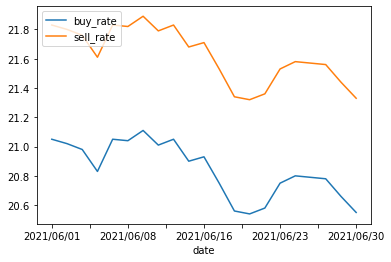


加拿大幣(CAD)



/usr/local/Caskroom/miniconda/base/envs/my_test/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rate.bot.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


            buy_rate  sell_rate
date                           
2021/06/01     22.48      23.39
2021/06/02     22.43      23.34
2021/06/03     22.45      23.36
2021/06/04     22.35      23.26
2021/06/07     22.41      23.32
2021/06/08     22.41      23.32
2021/06/09     22.46      23.37
2021/06/10     22.35      23.26
2021/06/11     22.34      23.25
2021/06/15     22.28      23.19
2021/06/16     22.24      23.15
2021/06/17     22.08      22.99
2021/06/18     21.98      22.89
2021/06/21     21.91      22.82
2021/06/22     22.07      22.98
2021/06/23     22.27      23.18
2021/06/24     22.27      23.18
2021/06/25     22.17      23.08
2021/06/28     22.19      23.10
2021/06/29     22.08      22.99
2021/06/30     21.98      22.89


<Figure size 720x576 with 0 Axes>

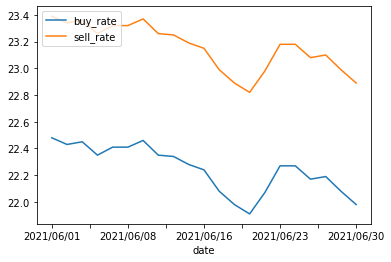


新加坡幣(SGD)



/usr/local/Caskroom/miniconda/base/envs/my_test/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rate.bot.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


            buy_rate  sell_rate
date                           
2021/06/01     20.36      21.27
2021/06/02     20.34      21.25
2021/06/03     20.33      21.24
2021/06/04     20.28      21.19
2021/06/07     20.35      21.26
2021/06/08     20.35      21.26
2021/06/09     20.40      21.31
2021/06/10     20.31      21.22
2021/06/11     20.31      21.22
2021/06/15     20.28      21.19
2021/06/16     20.31      21.22
2021/06/17     20.17      21.08
2021/06/18     20.15      21.06
2021/06/21     20.18      21.09
2021/06/22     20.18      21.09
2021/06/23     20.23      21.14
2021/06/24     20.24      21.15
2021/06/25     20.22      21.13
2021/06/28     20.20      21.11
2021/06/29     20.19      21.10
2021/06/30     20.15      21.06


<Figure size 720x576 with 0 Axes>

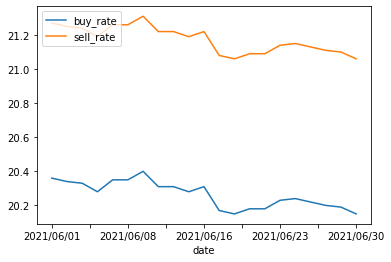


瑞士法郎(CHF)



/usr/local/Caskroom/miniconda/base/envs/my_test/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rate.bot.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


            buy_rate  sell_rate
date                           
2021/06/01     29.94      31.14
2021/06/02     30.00      31.20
2021/06/03     29.93      31.13
2021/06/04     29.78      30.98
2021/06/07     29.98      31.18
2021/06/08     30.01      31.21
2021/06/09     30.15      31.35
2021/06/10     30.05      31.25
2021/06/11     30.06      31.26
2021/06/15     30.00      31.20
2021/06/16     30.02      31.22
2021/06/17     29.63      30.83
2021/06/18     29.46      30.66
2021/06/21     29.48      30.68
2021/06/22     29.59      30.79
2021/06/23     29.68      30.88
2021/06/24     29.61      30.81
2021/06/25     29.57      30.77
2021/06/28     29.59      30.79
2021/06/29     29.49      30.69
2021/06/30     29.39      30.59


<Figure size 720x576 with 0 Axes>

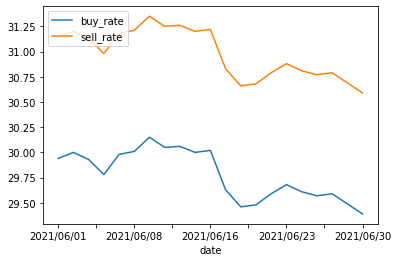


日圓(JPY)



/usr/local/Caskroom/miniconda/base/envs/my_test/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rate.bot.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [29]:
# 先到牌告匯率首頁，爬取所有貨幣的種類
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url, verify=False)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

for rate in rate_table:
    # 擷取匯率表格，把各貨幣資料擷取出來，查詢其歷史匯率
    currency = rate.find(name='div', attrs={'class':'visible-phone print_hide'})
    print(currency.get_text().replace(" ", ""))  # 貨幣種類

    # 針對美金，找到其「歷史匯率」的首頁 
    history_link = rate.find(name='td', attrs={'data-table':'歷史匯率'})
    history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁

    #
    # 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
    #
    # 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
    quote_history_url = history_rate_link.replace("history", "quote/2021-06")
    resp = requests.get(quote_history_url, verify=False)
    resp.encoding = 'utf-8'
    history = BeautifulSoup(resp.text, "lxml")
    history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')

    #
    # 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
    #
    date_history = list()
    history_buy = list()
    history_sell = list()

    for history_rate in history_table:
        # 擷取日期資料
        date_string = history_rate.a.get_text()
        date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
        date_history.append(date)  # 日期歷史資料

        history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
        history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
        history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

    # 將匯率資料建成dataframe形式
    HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                        'buy_rate':history_buy,
                                        'sell_rate':history_sell})

    HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
    HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)
    print(HistoryExchangeRate)

    # 畫出歷史匯率軌跡圖
    plt.figure(figsize=(10, 8))
    HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
    plt.legend(loc="upper left")
    plt.show()

In [ ]:
#pandas 版本
for rt in rate_table:
  print(rt['name'])
  country  = rt['name'].split('(')[1].replace(')','')
  url = f"https://rate.bot.com.tw/xrt/quote/2020-03/{country}"
  resp = requests.get(url)
  resp.encoding = 'utf-8'

  #
  # 擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖
  #
  html = BeautifulSoup(resp.text)
  print(html.find('tbody').find_all('tr')[0].find_all('td')[0].text)
  date_list =[]
  sell_list=[]
  buy_list=[]
  for d in html.find('tbody').find_all('tr'):
      date_list.append(d.find_all('td')[0].text[5:])
      buy_list.append(d.find_all('td')[2].text)
      sell_list.append(d.find_all('td')[3].text)
  buy_list = [float(d) for d in buy_list]
  sell_list = [float(d) for d in sell_list]
  data_list = {'2020 date':date_list,'buy':buy_list,'sell':sell_list}
  data_df = pd.DataFrame(data_list)
  data_df = data_df.set_index('2020 date')
  data_df = data_df.sort_index(ascending=True)
  plt.figure(figsize=(10, 8))
  data_df[['buy','sell']].plot(kind='line',title=rt['name'],fontproperties="SimSun")
  plt.legend(loc="upper left")
  plt.show()